In [1]:
import networkx as nx
import numpy as np
import torch
from model import CaT
from CaT.datasets import reorder_dag, get_full_ordering
from utils.inference import CausalInference
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 100
max_iters = 50000
eval_interval = 100
eval_iters = 100
validation_fraction = 0.3
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 5e-3
ff_n_embed = 30
num_heads = 2
n_layers = 2
embed_dim = 30
head_size = 30


We create data from a 'true' DAG (which is DAGnx3 below) but also provide two other DAGs which are incorrect in different ways. DAGnx1 is fully exogenous, and DAGnx2 has one missing edge and another directed edge reversed.

We imagine we are interested in the 'total' effect of X -> Y.  As these simulations are linear, this effect can be calculated easily by hand.

In the case where X1 -> Y and X1 -> X2 -> Y, the total effect is the sum of the effect from both paths. e.g. if X1 -> Y has a coefficient of  0.8,  X1 -> X2 of 0.8, and X2 -> Y of 0.4, then the total effect is 0.8 + (0.8 x 0.4) = 1.12

In [2]:
def generate_data(N, d=1):
    DAGnx1 = nx.DiGraph()
    DAGnx2 = nx.DiGraph()
    DAGnx3 = nx.DiGraph()  # correct graph
    
    Ux1 = np.random.randn(N,d)
    X1 =  Ux1

    Ux2 = np.random.randn(N,d)
    X2 =  0.8 * X1 + Ux2
    
    X20 = Ux2
    X21 = 0.8 + Ux2

    Uy = np.random.randn(N,d)
    Y =  0.8 * X1 + 0.4 * X2 + Uy  # 0.4*0.8   + 0.8 = 1.12  Total effect
    
    Ux3 = np.random.randn(N,d)
    X3 = 0.7 * Y + 0.6 * X1 + Ux3

    Y0 = 0.4 * X20 + Uy 
    Y1 = 0.8 + 0.4 * X21 + Uy

    all_data_dict = {'X1': X1, 'X2': X2, 'X3': X3, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X1': 'cont', 'X2': 'cont', 'X3': 'cont', 'Y': 'cont'}

    DAGnx1.add_edges_from([('X1', 'Y'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx1 = reorder_dag(dag=DAGnx1)  # topologically sorted dag
    var_names1 = list(DAGnx1.nodes())  # topologically ordered list of variables
    all_data1 = np.stack([all_data_dict[key] for key in var_names1], axis=1)
    causal_ordering1 = get_full_ordering(DAGnx1)
    ex_dag_stuff = (all_data1, DAGnx1, var_names1, causal_ordering1, var_types)
    
    DAGnx2.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X2', 'Y'), ('X3', 'Y')])
    DAGnx2 = reorder_dag(dag=DAGnx2)  # topologically sorted dag
    var_names2 = list(DAGnx2.nodes())  # topologically ordered list of variables
    all_data2 = np.stack([all_data_dict[key] for key in var_names2], axis=1)
    causal_ordering2 = get_full_ordering(DAGnx2)
    mediated_dag_stuff = (all_data2, DAGnx2, var_names2, causal_ordering2, var_types)
    
    DAGnx3.add_edges_from([('X1', 'Y'), ('X1', 'X2'), ('X1', 'X3'), ('X2', 'Y'), ('Y', 'X3')])
    DAGnx3 = reorder_dag(dag=DAGnx3)  # topologically sorted dag
    var_names3 = list(DAGnx3.nodes())  # topologically ordered list of variables
    all_data3 = np.stack([all_data_dict[key] for key in var_names3], axis=1)
    causal_ordering3 = get_full_ordering(DAGnx3)
    correct_dag_stuff =  (all_data3, DAGnx3, var_names3, causal_ordering3, var_types)

    return ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1

d=1
_, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  
ex_dag_stuff, mediated_dag_stuff, correct_dag_stuff, Y0, Y1 = generate_data(N=sample_size, d=d)

all_data1, DAGnx1, var_names1, causal_ordering1, var_types1 = ex_dag_stuff
all_data2, DAGnx2, var_names2, causal_ordering2, var_types2 = mediated_dag_stuff
all_data3, DAGnx3, var_names3, causal_ordering3, var_types3 = correct_dag_stuff

print(var_names1, 'ATE of X1 on Y:', ATE)
print(all_data1.shape)

['X1', 'X2', 'X3', 'Y'] ATE of X1 on Y: [1.12]
(100000, 4, 1)


Incorrect DAG 1:


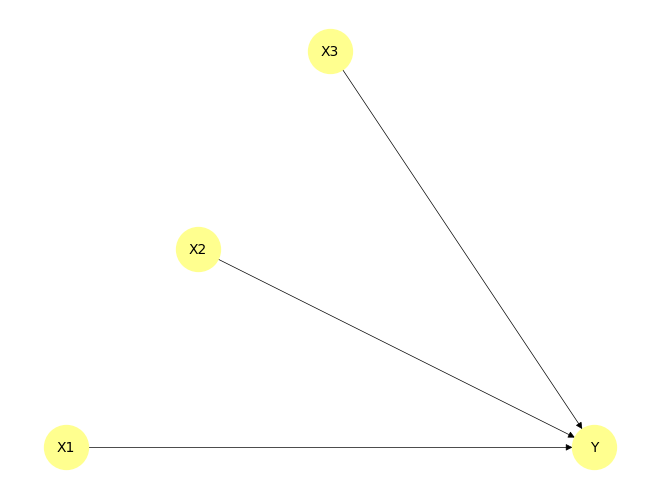

Incorrect DAG 2:


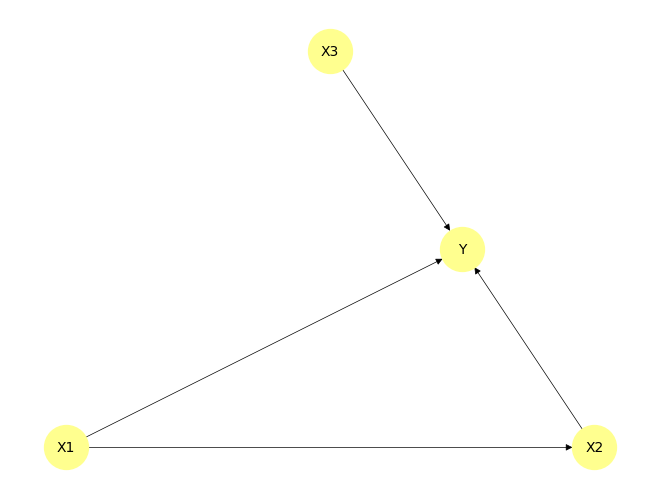

Correct DAG:


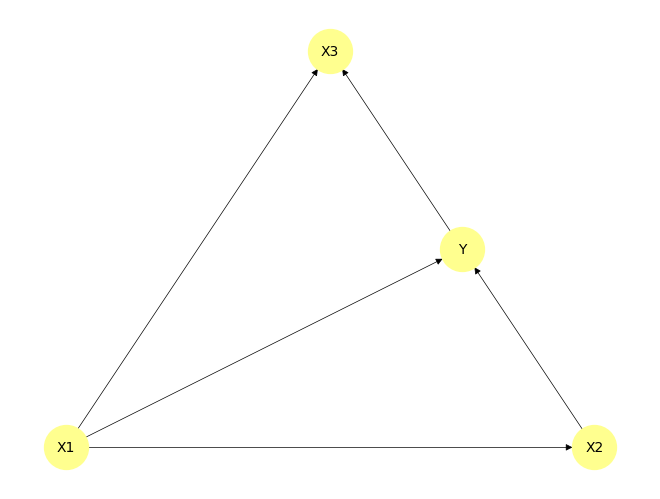

In [3]:
print('Incorrect DAG 1:')
nx.draw_planar(
    DAGnx1,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Incorrect DAG 2:')
nx.draw_planar(
    DAGnx2,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

print('Correct DAG:')
nx.draw_planar(
    DAGnx3,
    with_labels=True,
    node_size=1000,
    node_color="#ffff8f",
    width=0.5,
    font_size=10,
)
plt.show()

We run the model with the same data each time (although the column ordering of the data is different in each case, according to the assumed underlying DAG), and provide fit statistics as well as estimated causal links.

### Incorrect DAG 1 (fully exogenous)

In [4]:
indices = np.arange(0, len(all_data1))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data1[train_inds]
val_data = all_data1[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data1.shape[2]

model1 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx1,
                    causal_ordering=causal_ordering1,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types1, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model1.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model1.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model1(X=xb, targets=xb_mod
                                )

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model1.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model1(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model1.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 50000: train_loss 1.1714, val loss 1.1955
step 100 of 50000: train_loss 0.6982, val loss 0.6951
step 200 of 50000: train_loss 0.6808, val loss 0.6595
step 300 of 50000: train_loss 0.6758, val loss 0.6760
step 400 of 50000: train_loss 0.6559, val loss 0.6740
step 500 of 50000: train_loss 0.6756, val loss 0.6862
step 600 of 50000: train_loss 0.6968, val loss 0.6991
step 700 of 50000: train_loss 0.6766, val loss 0.6632
step 800 of 50000: train_loss 0.6736, val loss 0.6954
step 900 of 50000: train_loss 0.6590, val loss 0.6811
step 1000 of 50000: train_loss 0.6763, val loss 0.6899
step 1100 of 50000: train_loss 0.6772, val loss 0.6599
step 1200 of 50000: train_loss 0.7002, val loss 0.7091
step 1300 of 50000: train_loss 0.6558, val loss 0.6804
step 1400 of 50000: train_loss 0.6739, val loss 0.6870
step 1500 of 50000: train_loss 0.6747, val loss 0.7085
step 1600 of 50000: train_loss 0.6578, val loss 0.6745
step 1700 of 50000: train_loss 0.6603, val loss 0.6701
step 1800 of 50000: tr

/home/matthewvowels/GitHub/Causal_Transformer/utils/inference.py:50: UserWarning: No mask has been specified. If padding has been used, the absence of a mask may lead to incorrect results.
  warnings.warn(


ATE: [1.12] est ATE: [0.24324878] error: [0.87675122]
Mean Squared Error Across All Vars: tensor(1.7037)
Mean Squared Error Across Outcome: tensor(0.6656)


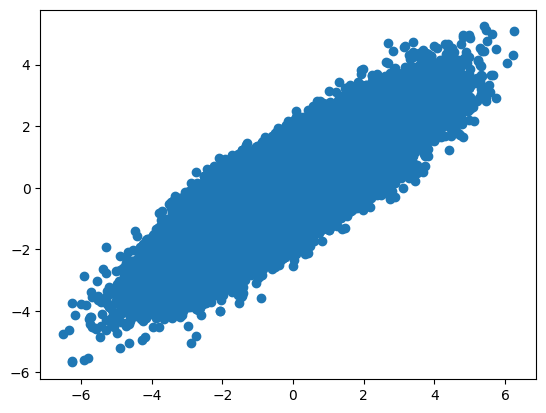

In [5]:
   
model1.eval()
inf = CausalInference(model=model1, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names1.index(effect_var)

preds0 = inf.forward(all_data1, int_nodes_vals0)
preds1 = inf.forward(all_data1, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model1(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Incorrect DAG 2 (missing and reverse edges)

In [6]:
indices = np.arange(0, len(all_data2))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data2[train_inds]
val_data = all_data2[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data2.shape[2]

model2 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx2,
                    causal_ordering=causal_ordering2,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types2, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model2.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model2.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model2(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model2.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model2(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model2.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 50000: train_loss 2.7140, val loss 2.7551
step 100 of 50000: train_loss 1.6856, val loss 1.6714
step 200 of 50000: train_loss 1.7098, val loss 1.6826
step 300 of 50000: train_loss 1.7293, val loss 1.6955
step 400 of 50000: train_loss 1.7192, val loss 1.7076
step 500 of 50000: train_loss 1.7010, val loss 1.6674
step 600 of 50000: train_loss 1.6823, val loss 1.6626
step 700 of 50000: train_loss 1.6808, val loss 1.7171
step 800 of 50000: train_loss 1.6758, val loss 1.6900
step 900 of 50000: train_loss 1.6901, val loss 1.6811
step 1000 of 50000: train_loss 1.6877, val loss 1.6557
step 1100 of 50000: train_loss 1.6500, val loss 1.6821
step 1200 of 50000: train_loss 1.6711, val loss 1.6782
step 1300 of 50000: train_loss 1.7011, val loss 1.6948
step 1400 of 50000: train_loss 1.7033, val loss 1.6380
step 1500 of 50000: train_loss 1.7064, val loss 1.7089
step 1600 of 50000: train_loss 1.6918, val loss 1.6828
step 1700 of 50000: train_loss 1.6787, val loss 1.6921
step 1800 of 50000: tr

ATE: [1.12] est ATE: [0.49129122] error: [0.62870878]
Mean Squared Error Across All Vars: tensor(1.5402)
Mean Squared Error Across Outcome: tensor(0.6690)


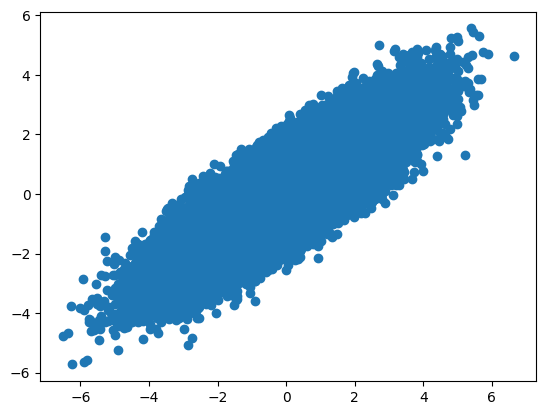

In [7]:
   
model2.eval()
inf = CausalInference(model=model2, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names2.index(effect_var)

preds0 = inf.forward(all_data2, int_nodes_vals0)
preds1 = inf.forward(all_data2, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model2(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())

## Correct DAG

In [8]:
indices = np.arange(0, len(all_data3))
np.random.shuffle(indices)

val_inds = indices[:int(validation_fraction*len(indices))]
train_inds = indices[int(validation_fraction*len(indices)):]
train_data = all_data3[train_inds]
val_data = all_data3[val_inds]
train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()

input_dim = all_data3.shape[2]

model3 = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    embed_dim= embed_dim,
                    dag=DAGnx3,
                    causal_ordering=causal_ordering3,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types3, activation_function='Swish'
                    ).to(device)

optimizer = torch.optim.AdamW(model3.parameters(), lr=learning_rate)

def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

all_var_losses = {}
for iter_ in range(0, max_iters):
    # train and update the model
    model3.train()

    xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
    xb_mod = torch.clone(xb.detach())
    X, loss, loss_dict = model3(X=xb, targets=xb_mod)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()


    if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
        for key in loss_dict.keys():
            if key not in all_var_losses.keys():
                all_var_losses[key] = []
            all_var_losses[key].append(loss_dict[key])

        model3.eval()
        eval_loss = {}
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):

                xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                               batch_size=batch_size)
                xb_mod = torch.clone(xb.detach())
                X, loss, loss_dict = model3(X=xb, targets=xb_mod)
                losses[k] = loss.item()
            eval_loss[split] = losses.mean()
        model3.train()
        print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")
 

step 0 of 50000: train_loss 6.3351, val loss 6.4850
step 100 of 50000: train_loss 2.9934, val loss 2.9557
step 200 of 50000: train_loss 3.0423, val loss 3.0331
step 300 of 50000: train_loss 3.0441, val loss 3.0214
step 400 of 50000: train_loss 3.0036, val loss 2.9910
step 500 of 50000: train_loss 3.0132, val loss 3.0157
step 600 of 50000: train_loss 3.0508, val loss 2.9956
step 700 of 50000: train_loss 2.9881, val loss 2.9940
step 800 of 50000: train_loss 3.0222, val loss 2.9891
step 900 of 50000: train_loss 3.0391, val loss 3.0310
step 1000 of 50000: train_loss 3.0679, val loss 2.9819
step 1100 of 50000: train_loss 3.0196, val loss 2.9741
step 1200 of 50000: train_loss 3.0208, val loss 3.0380
step 1300 of 50000: train_loss 3.0300, val loss 2.9760
step 1400 of 50000: train_loss 3.0023, val loss 3.0640
step 1500 of 50000: train_loss 3.0481, val loss 2.9734
step 1600 of 50000: train_loss 3.0580, val loss 2.9856
step 1700 of 50000: train_loss 3.0054, val loss 2.9810
step 1800 of 50000: tr

ATE: [1.12] est ATE: [1.1106011] error: [0.0093989]
Mean Squared Error Across All Vars: tensor(1.0026)
Mean Squared Error Across Outcome: tensor(0.9941)


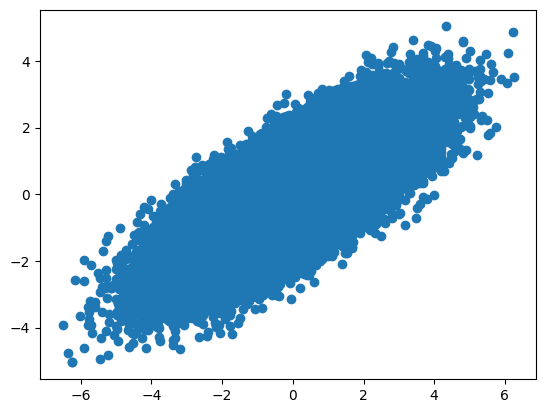

In [9]:
   
model3.eval()
inf = CausalInference(model=model3, device=device)

int_nodes_vals0 = {'X1':np.array([0.0,])}
int_nodes_vals1 = {'X1':np.array([1.0,])}
effect_var = 'Y'
effect_index = var_names3.index(effect_var)

preds0 = inf.forward(all_data3, int_nodes_vals0)
preds1 = inf.forward(all_data3, int_nodes_vals1)
ATE_pred = (preds1[:,effect_index,:] - preds0[:,effect_index,:]).mean(0)
eATE = np.abs(ATE_pred - ATE)
print('ATE:', ATE, 'est ATE:', ATE_pred, 'error:', eATE)

preds = model3(train_data.to(device))
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
print('Mean Squared Error Across All Vars:', ((train_data - preds.detach().cpu())**2).mean())
print('Mean Squared Error Across Outcome:', ((train_data[:,effect_index,:] - preds[:,effect_index,:].detach().cpu())**2).mean())